In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from scipy import stats

In [4]:
from sklearn.metrics import mean_squared_error, explained_variance_score

## Load Data

In [5]:
data = pd.read_csv('Data_Files/train.csv')
data.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,2ZR62O53,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,English
1,ZJ31SS7Q,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,English
2,I31VI9RK,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,Portuguese
3,6GP9WLYR,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,English
4,3DVR0TDD,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,English


## Data Preprocessing

### Add a constant for eliminating negative values

In [6]:
data['Followers gained'].min()

-15772

In [7]:
numeric = data.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196161750,215250,222720,27716,3246298,1734810,93036735
1,6091677300,211845,310998,25610,5310163,1370184,89705964
2,5644590915,515280,387315,10976,1767635,1023779,102611607
3,3970318140,517740,300575,7714,3944850,703986,106546942
4,3671000070,123660,285644,29602,8938903,2068424,78998587


In [8]:
numeric += 15772

In [9]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196177522,231022,238492,43488,3262070,1750582,93052507
1,6091693072,227617,326770,41382,5325935,1385956,89721736
2,5644606687,531052,403087,26748,1783407,1039551,102627379
3,3970333912,533512,316347,23486,3960622,719758,106562714
4,3671015842,139432,301416,45374,8954675,2084196,79014359


In [10]:
numeric['Followers gained'].min()

0

In [11]:
for col in numeric.columns:
    print(f"{col}: {numeric[col].min()}\n")

Watch time(Minutes): 154539937

Stream time(minutes): 21967

Peak viewers: 16954

Average viewers: 16085

Followers: 19432

Followers gained: 0

Views gained: 191560



### Log transformation

In [12]:
numeric = numeric.transform(np.log)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,22.547198,12.350268,12.382091,10.680240,14.997873,14.375459,18.348674
1,22.530192,12.335420,12.697012,10.630601,15.488099,14.141901,18.312224
2,22.453966,13.182615,12.906908,10.194215,14.394036,13.854299,18.446615
3,22.102116,13.187237,12.664595,10.064160,15.191912,13.486670,18.484244
4,22.023734,11.845332,12.616247,10.722695,16.007686,14.549894,18.185140


### Remove outliers

In [13]:
sns.set_theme(style='whitegrid')

In [14]:
def remove_outliers(x):
    global numeric
    data_var = numeric[x]
    
    Q75, Q25 = np.percentile(data_var, [75, 25])
    IQR = Q75 - Q25
    lower_bound = Q25 - (1.5*IQR)
    upper_bound = Q75 + (1.5*IQR)
    
    numeric = numeric[(numeric[x] >= lower_bound) & (numeric[x] <= upper_bound)].reset_index()
    numeric.drop('index', axis=1, inplace=True)
    
    print(f'{numeric.info()}\n')

In [15]:
for col in numeric.columns:
    remove_outliers(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   783 non-null    float64
 1   Stream time(minutes)  783 non-null    float64
 2   Peak viewers          783 non-null    float64
 3   Average viewers       783 non-null    float64
 4   Followers             783 non-null    float64
 5   Followers gained      783 non-null    float64
 6   Views gained          783 non-null    float64
dtypes: float64(7)
memory usage: 42.9 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   731 non-null    float64
 1   Stream time(minutes)  731 non-null    float64
 2   Peak viewers          731 non-null    float64
 3   Average viewers       731 

### Polynomial Regression

In [16]:
equations = {}

fg = 'Followers gained'

def display_reg(x, y, degree=3):
    fig, ax = plt.subplots(figsize=(20,16))
    
    horizontal = np.linspace(numeric[x].min(), numeric[x].max(), len(numeric[x]))
    function_model = np.poly1d(np.polyfit(numeric[x].values, numeric[y].values, degree))
    
    equations[y] = function_model
    
    plt.scatter(data=numeric, x=x, y=y, zorder=1)
    plt.plot(horizontal, function_model(horizontal), zorder=2, color='r')
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.show()

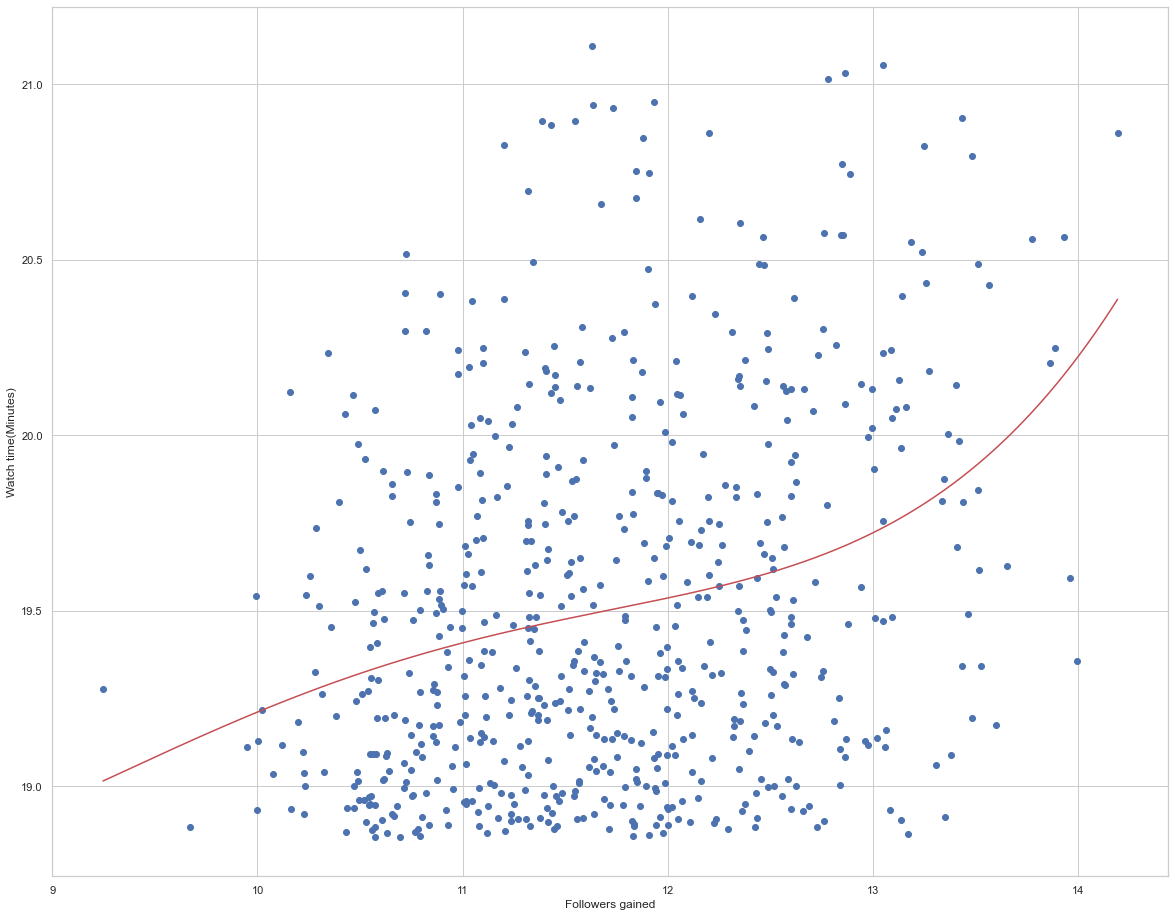

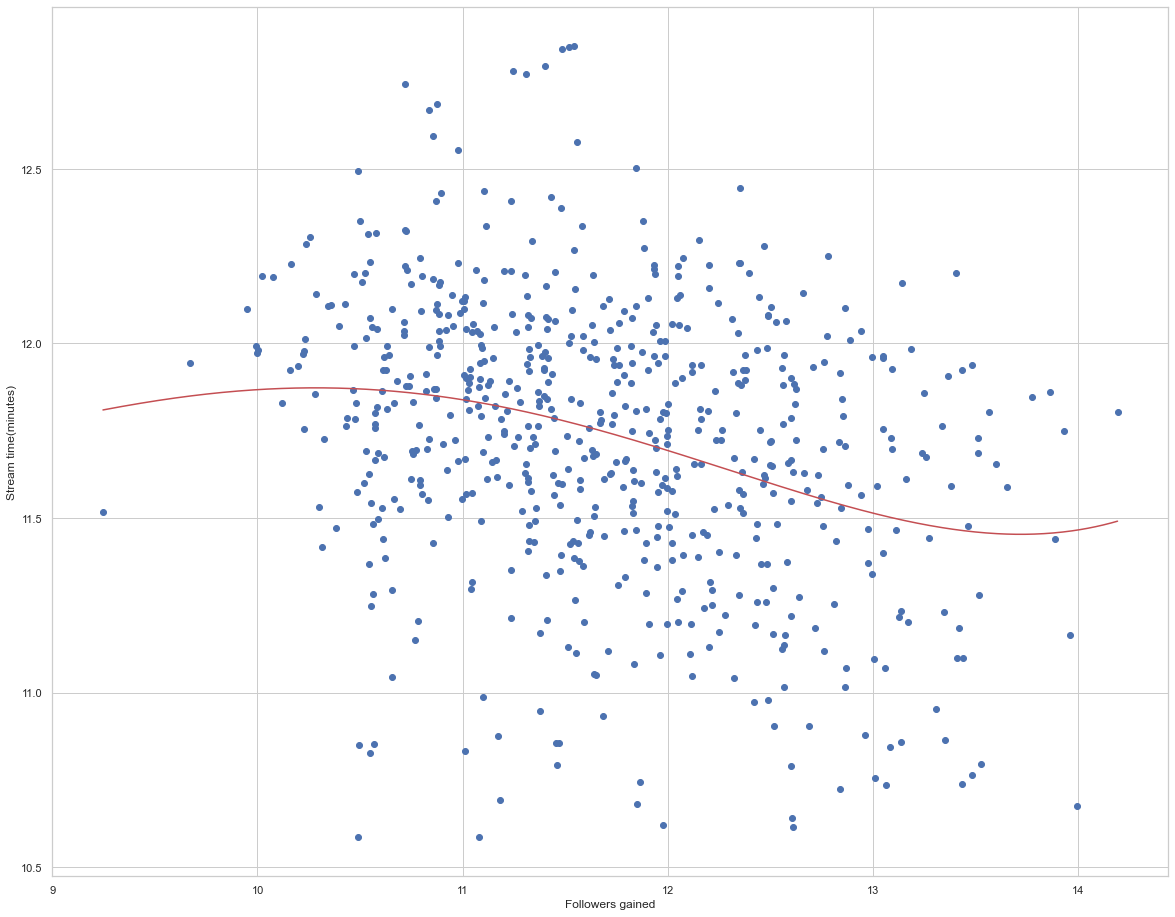

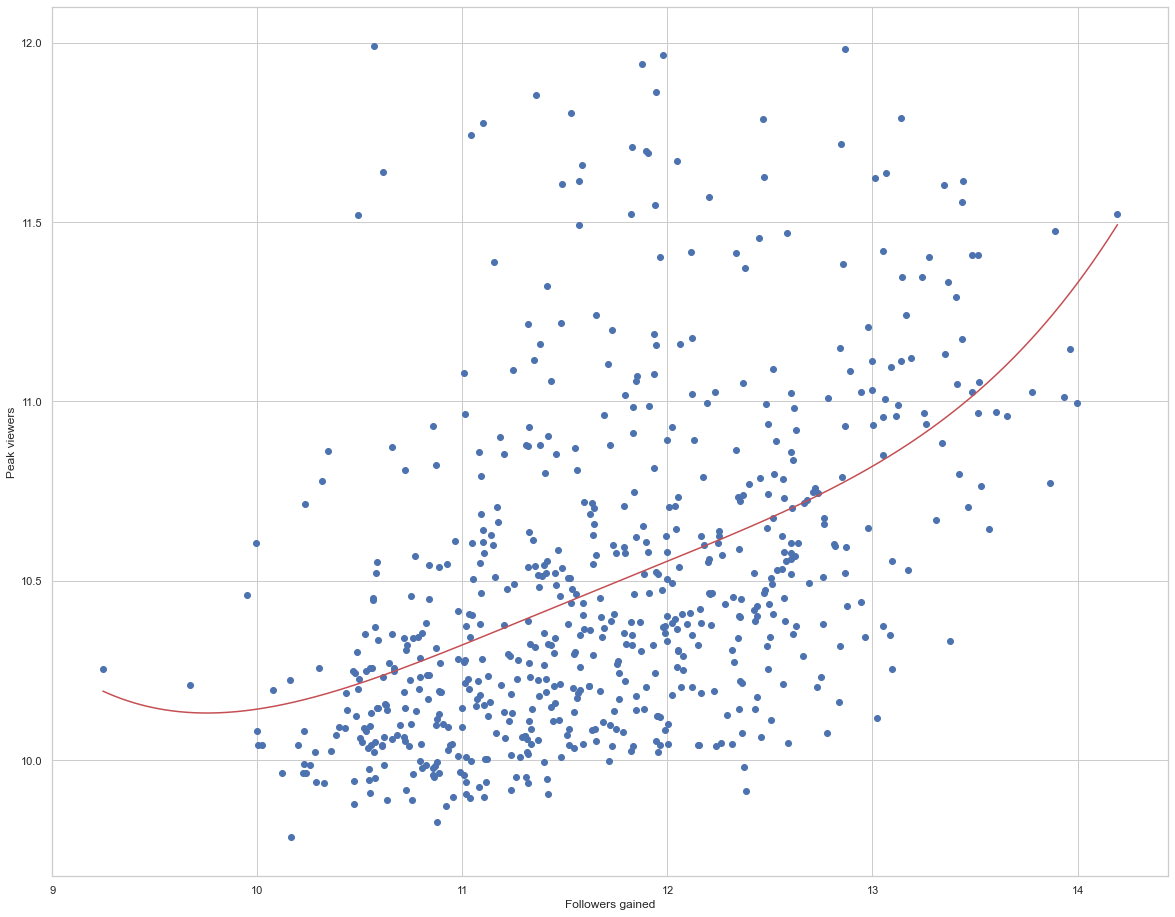

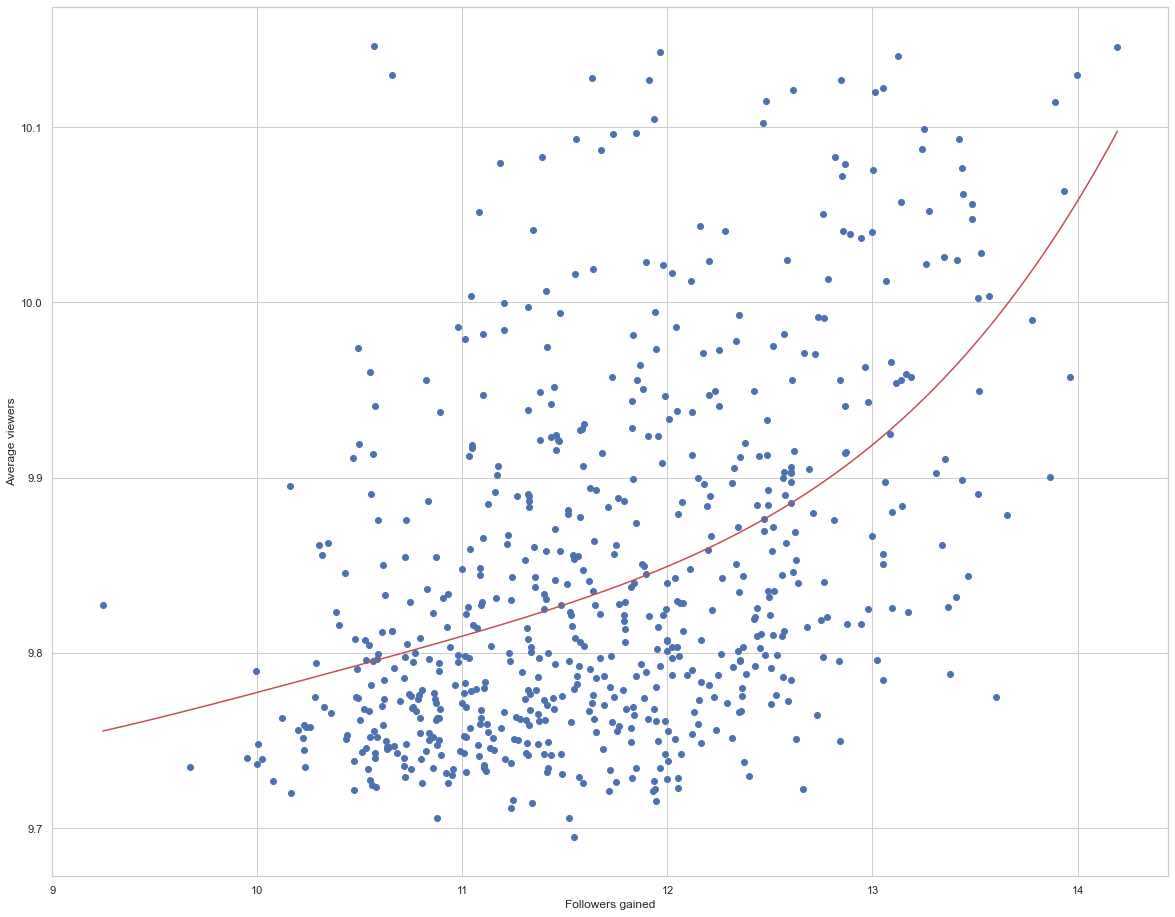

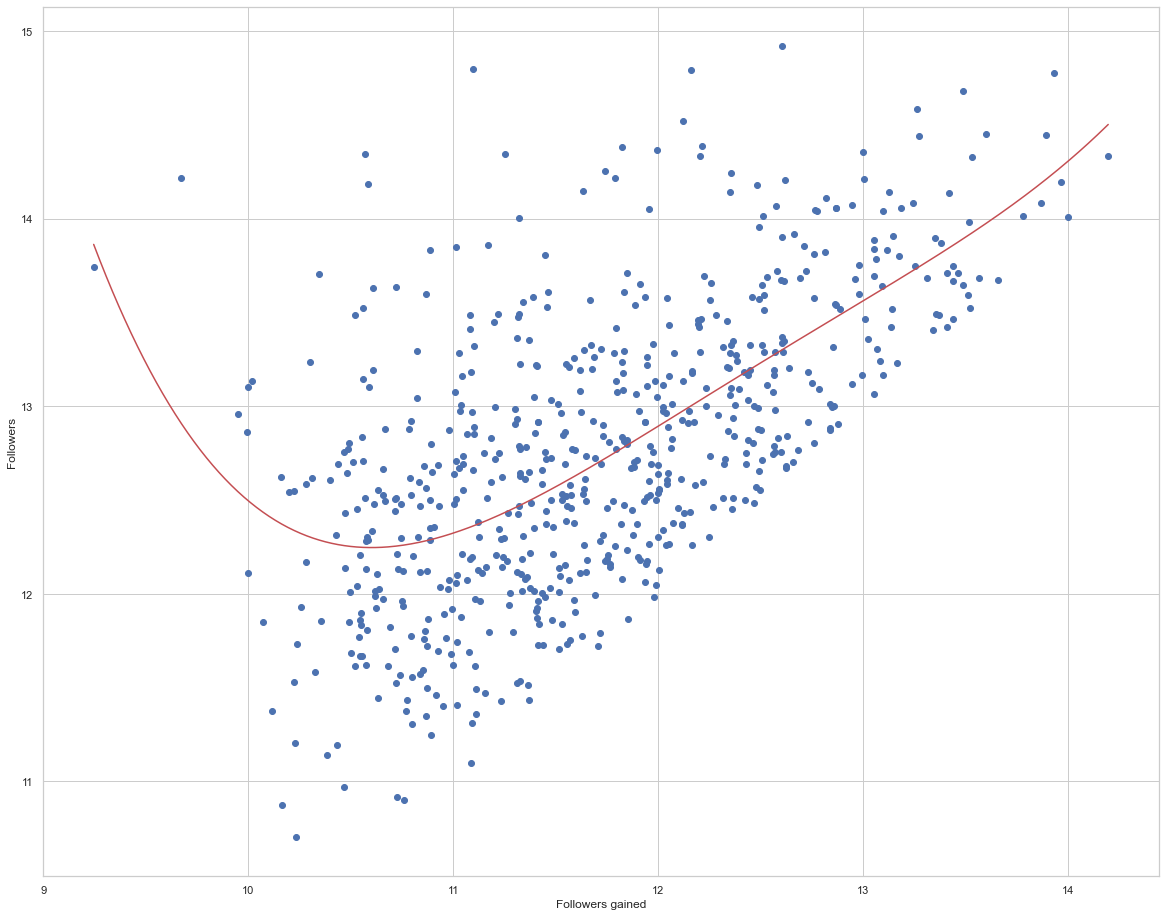

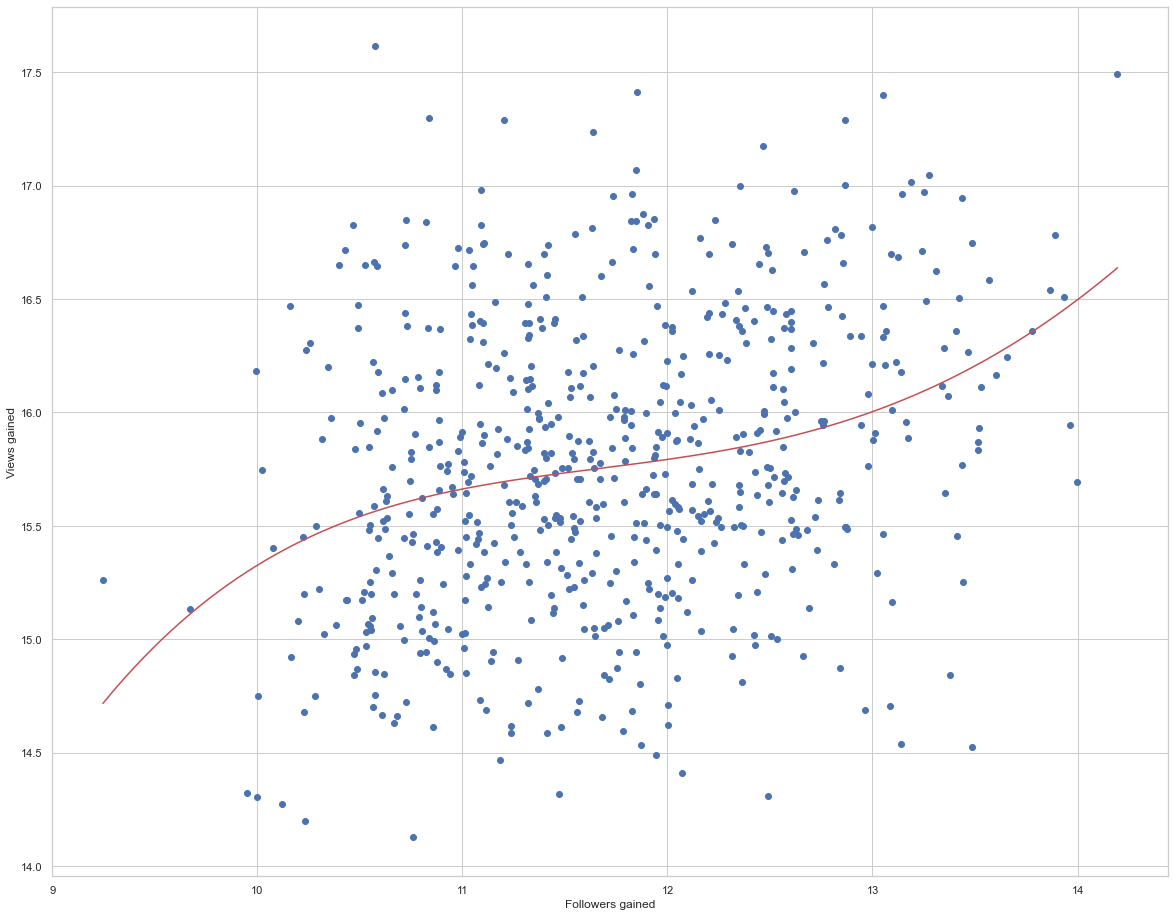

In [17]:
y_columns = numeric.drop('Followers gained', axis=1).columns

for y in y_columns:
    display_reg(fg, y, 4)

In [18]:
equations

{'Watch time(Minutes)': poly1d([ 5.45370343e-03, -2.29734583e-01,  3.58180373e+00, -2.42893720e+01,
         7.91222948e+01]),
 'Stream time(minutes)': poly1d([ 3.43288233e-03, -1.44195517e-01,  2.20455750e+00, -1.45278641e+01,
         4.65571269e+01]),
 'Peak viewers': poly1d([ 9.90820191e-03, -4.59582942e-01,  7.99009070e+00, -6.14748316e+01,
         1.86382020e+02]),
 'Average viewers': poly1d([ 7.56935002e-04, -3.11642245e-02,  4.81970404e-01, -3.28687457e+00,
         1.80440357e+01]),
 'Followers': poly1d([ 2.59564762e-02, -1.30137841e+00,  2.44464023e+01, -2.03254827e+02,
         6.42218063e+02]),
 'Views gained': poly1d([-3.45476341e-03,  2.06527921e-01, -4.40654275e+00,  4.05460392e+01,
        -1.21459443e+02])}

### Artificial Data Generation based on retrieved regression

In [19]:
cols = ['Watch time(Minutes)', 'Stream time(minutes)', 'Peak viewers', 
        'Average viewers', 'Followers', 'Views gained', 'Followers gained']

numeric = numeric.reindex(columns=cols)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329


In [20]:
fg = numeric['Followers gained']

raf = []
aug_data = pd.DataFrame()

while (len(raf) < 2*(10**3)):
    rand_fg = np.random.randint(fg.min(), fg.max())
    raf.append(rand_fg)
        
for key in equations:
    values = [(equations[key](fg)) for fg in raf]
    aug_data[key] = values

aug_data['Followers gained'] = raf
numeric = numeric.append(aug_data)

numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   2649 non-null   float64
 1   Stream time(minutes)  2649 non-null   float64
 2   Peak viewers          2649 non-null   float64
 3   Average viewers       2649 non-null   float64
 4   Followers             2649 non-null   float64
 5   Views gained          2649 non-null   float64
 6   Followers gained      2649 non-null   float64
dtypes: float64(7)
memory usage: 165.6 KB


## Feature Engineering

In [21]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329


<AxesSubplot:>

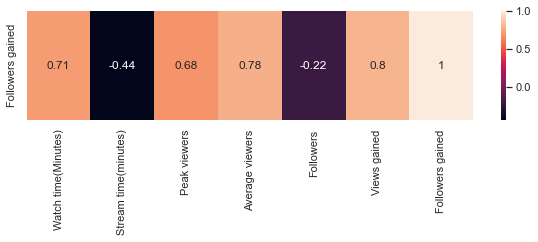

In [22]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [23]:
# How much each viewer spends time in watching the stream?
numeric['Watch time(Minutes)/Average viewers'] = numeric['Watch time(Minutes)'] / numeric['Average viewers']

# If all the followers viewed the stream, how much time would each of them spend?
numeric['Watch time(Minutes)/Followers'] = numeric['Watch time(Minutes)'] / numeric['Followers']

# What proportion of Peak viewers is out of total Followers?
numeric['Peak viewers/Followers'] = numeric['Peak viewers'] / numeric['Followers']

# What proportion of Average viewers is out of total Followers?
numeric['Average viewers/Followers'] = numeric['Average viewers'] / numeric['Followers']

# How much views will be optained from a single minute of streaming?
numeric['Views gained/Stream time(minutes)'] = numeric['Views gained'] / numeric['Stream time(minutes)']

<AxesSubplot:>

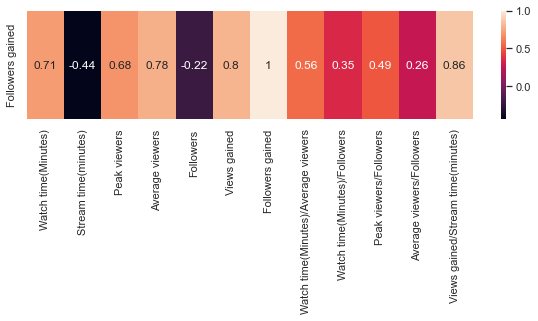

In [24]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [25]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286,2.084288,1.491989,0.757430,0.715827,1.394947
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765,2.080152,1.521469,0.784113,0.731422,1.454223
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929,2.086659,1.552767,0.884631,0.744140,1.428828
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320,2.098814,1.604999,0.840790,0.764717,1.344036
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329,2.073176,1.621685,0.866053,0.782223,1.408894


In [26]:
numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Watch time(Minutes)                  2649 non-null   float64
 1   Stream time(minutes)                 2649 non-null   float64
 2   Peak viewers                         2649 non-null   float64
 3   Average viewers                      2649 non-null   float64
 4   Followers                            2649 non-null   float64
 5   Views gained                         2649 non-null   float64
 6   Followers gained                     2649 non-null   float64
 7   Watch time(Minutes)/Average viewers  2649 non-null   float64
 8   Watch time(Minutes)/Followers        2649 non-null   float64
 9   Peak viewers/Followers               2649 non-null   float64
 10  Average viewers/Followers            2649 non-null   float64
 11  Views gained/Stream time(minut

## Train, Test, Val Split & Data Scaling

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [28]:
X = numeric.drop('Followers gained', axis=1).values
y = numeric['Followers gained'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=101)

In [29]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

## Models Generation

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Deep Neural Network

In [33]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import keras.backend as K
from keras.losses import mean_squared_error as mse

In [36]:
inputs = Input(shape=(11))

x1 = Dense(430, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(inputs)
d1 = Dropout(0.6)(x1)

x2 = Dense(430, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d1)
d2 = Dropout(0.6)(x2)

x3 = Dense(256, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d2)
d3 = Dropout(0.6)(x3)

x4 = Dense(256, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d3)
d4 = Dropout(0.6)(x4)

x5 = Dense(128, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d4)
d5 = Dropout(0.6)(x5)

x6 = Dense(128, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d5)
d6 = Dropout(0.6)(x6)

x7 = Dense(32, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d6)
d7 = Dropout(0.6)(x7)

x8 = Dense(32, activation='selu', kernel_initializer=keras.initializers.RandomUniform())(d7)
d8 = Dropout(0.6)(x8)

outputs = Dense(1)(d8)

model = keras.Model(inputs=inputs, outputs=outputs)

def rmse(y_true, y_pred):
    return K.sqrt(mse(y_true, y_pred))

model.compile(
    loss=rmse, optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [37]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=75)

Epoch 1/75
67/67 [==============================] - 2s 9ms/step - loss: 5.5457 - val_loss: 1.1611
Epoch 2/75
67/67 [==============================] - 0s 7ms/step - loss: 2.7504 - val_loss: 1.1643
Epoch 3/75
67/67 [==============================] - 0s 7ms/step - loss: 2.5552 - val_loss: 0.9410
Epoch 4/75
67/67 [==============================] - 0s 7ms/step - loss: 2.4561 - val_loss: 1.1271
Epoch 5/75
67/67 [==============================] - 0s 7ms/step - loss: 2.4128 - val_loss: 0.6892
Epoch 6/75
67/67 [==============================] - 0s 7ms/step - loss: 2.2756 - val_loss: 0.9257
Epoch 7/75
67/67 [==============================] - 0s 7ms/step - loss: 2.2542 - val_loss: 0.9304
Epoch 8/75
67/67 [==============================] - 0s 7ms/step - loss: 2.3244 - val_loss: 0.8612
Epoch 9/75
67/67 [==============================] - 0s 7ms/step - loss: 2.2740 - val_loss: 0.6960
Epoch 10/75
67/67 [==============================] - 1s 8ms/step - loss: 2.3216 - val_loss: 0.9191
Epoch 11/75
67/67 [

### XGBRegressor

In [38]:
from xgboost import XGBRegressor

# Model generation and training
xgb_model = XGBRegressor(objective='reg:linear', 
                         n_estimators=5000, 
                         max_depth=15, 
                         eta=0.001, 
                         subsample=0.8, 
                         colsample_bytree=0.8, 
                         eval_metric='rmse')

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Make predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Train set performance
xgb_train_evs = explained_variance_score(y_train, train_pred)
xgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
xgb_test_evs = explained_variance_score(y_test, test_pred)
xgb_test_rmse = rmse(y_test, test_pred)

# Output results
xgb_results = f"""
XGBoost Train EVS: {xgb_train_evs}
XGBoost Train RMSE: {xgb_train_rmse}

XGBoost Test EVS: {xgb_test_evs}
XGBoost Test RMSE: {xgb_test_rmse}
"""

print(xgb_results)

[20:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.

XGBoost Train EVS: 0.9967052928294794
XGBoost Train RMSE: 0.11145082116127014

XGBoost Test EVS: 0.8445952957236605
XGBoost Test RMSE: 0.56349116563797



### LGBMRegressor

In [39]:
from lightgbm import LGBMRegressor as lgb

# Model generation and training
lgb_model = lgb(boosting_type='gbdt', objective='regression',
                num_leaves=150, learning_rate=0.001, n_estimators=10**4)
lgb_model.fit(X_train, y_train)

# Make predictions
train_pred = lgb_model.predict(X_train)
test_pred = lgb_model.predict(X_test)

# Train set performance
lgb_train_evs = explained_variance_score(y_train, train_pred)
lgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
lgb_test_evs = explained_variance_score(y_test, test_pred)
lgb_test_rmse = rmse(y_test, test_pred)

# Output results
lgb_results = f"""
LightGBM Train EVS: {lgb_train_evs}
LightGBM Train RMSE: {lgb_train_rmse}

LightGBM Test EVS: {lgb_test_evs}
LightGBM Test RMSE: {lgb_test_rmse}
"""

print(lgb_results)


LightGBM Train EVS: 0.9911311362137526
LightGBM Train RMSE: 0.12542520238007906

LightGBM Test EVS: 0.7123195181594686
LightGBM Test RMSE: 0.7693921580333197



### Random Forests Regressor

In [40]:
from sklearn.ensemble import RandomForestRegressor

# Model generation and training
forest = RandomForestRegressor(n_estimators=350, verbose=1)
forest.fit(X_train, y_train)

# Make predictions
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

# Train set performance
rf_train_evs = explained_variance_score(y_train, train_pred)
rf_train_rmse = rmse(y_train, train_pred)

# Test set performance
rf_test_evs = explained_variance_score(y_test, test_pred)
rf_test_rmse = rmse(y_test, test_pred)

# Output results
rf_results = f"""
Random Forests Train EVS: {rf_train_evs}
Random Forests Train RMSE: {rf_train_rmse}

Random Forests Test EVS: {rf_test_evs}
Random Forests Test RMSE: {rf_test_rmse}
"""

print(rf_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Random Forests Train EVS: 0.9918458773609383
Random Forests Train RMSE: 0.12026648980318665

Random Forests Test EVS: 0.89057006706295
Random Forests Test RMSE: 0.4716556176605354



[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


## Stacked Model

In [41]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Models to use
estimators = [
    ('XGBRegressor', xgb_model),
    ('LGBMRegressor', lgb_model),
    ('RFRegressor', forest)
]

# Build Stacked Model
stack_model = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

# Train Stacked Model
stack_model.fit(X_train, y_train)

# Make Predictions
sm_train_pred = stack_model.predict(X_train) 
sm_test_pred = stack_model.predict(X_test)

# Train Set Performance
sm_train_evs = explained_variance_score(y_train, sm_train_pred)
sm_train_rmse = rmse(y_train, sm_train_pred)

# Test Set Performance
sm_test_evs = explained_variance_score(y_test, sm_test_pred)
sm_test_rmse = rmse(y_test, sm_test_pred)

# Output results
sm_results = f"""
Stacked Model Train EVS: {sm_train_evs}
Stacked Model Train RMSE: {sm_train_rmse}

Stacked Model Test EVS: {sm_test_evs}
Stacked Model Test RMSE: {sm_test_rmse}
"""

print(sm_results)

[20:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    1.1s finished


[20:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


Stacked Model Train EVS: 0.9950354756935508
Stacked Model Train RMSE: 0.09394265333069227

Stacked Model Test EVS: 0.8665527409035786
Stacked Model Test RMSE: 0.512467992328783



[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


## Model Predictions

In [42]:
test = pd.read_csv('Data_Files/test.csv')
test.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Partnered,Mature,Language
0,97R8L3J0,154332060,27105,29983,5864,308815,8255635,0,0,Russian
1,6UV44QFF,154277370,87375,9437,1759,151886,3019137,1,1,French
2,2WKQZUGR,154125945,77475,9460,2106,411346,4832180,1,0,Turkish
3,R4DGVX2D,153988380,83325,11200,1787,272635,4345590,1,0,French
4,P8YSNIOI,153963765,110910,14329,1281,106365,1449834,1,1,English


In [43]:
test.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1, inplace=True)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,154332060,27105,29983,5864,308815,8255635
1,154277370,87375,9437,1759,151886,3019137
2,154125945,77475,9460,2106,411346,4832180
3,153988380,83325,11200,1787,272635,4345590
4,153963765,110910,14329,1281,106365,1449834


In [44]:
for col in test.columns:
    print(f"{col}: {test[col].min()}\n")

Watch time(Minutes): 122192850

Stream time(minutes): 3465

Peak viewers: 496

Average viewers: 235

Followers: 7102

Views gained: 956614



In [45]:
test = test.transform(np.log)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,18.854617,10.207473,10.308386,8.676587,12.640498,15.926407
1,18.854263,11.377964,9.152393,7.472501,11.930886,14.920482
2,18.853281,11.257711,9.154828,7.652546,12.927190,15.390808
3,18.852388,11.330504,9.323669,7.488294,12.515889,15.284672
4,18.852228,11.616474,9.570041,7.155396,11.574632,14.186960


In [46]:
test['Watch time(Minutes)/Average viewers'] = test['Watch time(Minutes)'] / test['Average viewers']
test['Watch time(Minutes)/Followers'] = test['Watch time(Minutes)'] / test['Followers']
test['Peak viewers/Followers'] = test['Peak viewers'] / test['Followers']
test['Average viewers/Followers'] = test['Average viewers'] / test['Followers']
test['Views gained/Stream time(minutes)'] = test['Views gained'] / test['Stream time(minutes)']

In [47]:
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,18.854617,10.207473,10.308386,8.676587,12.640498,15.926407,2.173045,1.491604,0.815505,0.686412,1.560269
1,18.854263,11.377964,9.152393,7.472501,11.930886,14.920482,2.523153,1.580290,0.767118,0.626316,1.311349
2,18.853281,11.257711,9.154828,7.652546,12.927190,15.390808,2.463661,1.458421,0.708184,0.591973,1.367135
3,18.852388,11.330504,9.323669,7.488294,12.515889,15.284672,2.517581,1.506276,0.744947,0.598303,1.348984
4,18.852228,11.616474,9.570041,7.155396,11.574632,14.186960,2.634687,1.628754,0.826812,0.618196,1.221279


In [48]:
test = scaler.fit_transform(test.values)

In [49]:
dnn_pred = model.predict(test)
stack_pred = stack_model.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


In [50]:
dnn_pred = dnn_pred.transpose()[0]
dnn_pred

array([11.800092 , 11.06785  , 11.708244 , 11.644267 , 10.363035 ,
       11.690654 , 11.110671 , 10.98633  , 10.69603  , 11.677722 ,
       11.679372 , 11.819312 , 11.549769 , 10.237633 , 11.648641 ,
       10.745369 , 11.833435 , 10.021063 , 10.270262 , 11.58183  ,
       11.207002 , 11.83062  , 10.08346  , 10.83564  , 10.448669 ,
       11.793546 , 11.533126 , 10.9836855,  9.662837 , 10.187506 ,
       11.700067 , 10.5158205, 11.683711 , 10.250576 , 10.158436 ,
       10.001113 , 10.1071   ,  9.961699 , 10.407297 , 11.55188  ,
       10.26922  , 11.810503 , 11.416679 , 10.327497 , 11.6037   ,
       10.229306 , 11.509292 , 10.816238 , 11.716852 , 10.485067 ,
       11.739592 , 10.980644 , 11.771915 , 11.8242035,  9.931339 ,
       11.660249 , 10.364318 , 10.123871 , 11.239761 , 10.99885  ,
       11.461808 , 10.996342 , 10.131268 , 10.385502 ,  9.591685 ,
       10.828424 , 11.725953 , 11.758922 , 10.555019 ,  9.780773 ,
       10.905344 , 11.653154 , 10.727258 , 11.75075  , 11.7817

In [51]:
stack_pred

array([12.39929094, 11.85461175, 12.13135116, 11.87256156, 11.52930648,
       12.01438813, 12.01811963, 11.79188412, 11.78230592, 11.97887234,
       11.9605128 , 11.51844676, 12.22473712, 11.36013566, 11.87016988,
       11.18070938, 12.81127084, 10.83040239, 11.42448746, 11.6866369 ,
       11.55535418, 12.84302316, 11.56809439, 11.71894129, 11.87898603,
       12.47400499, 11.75422965, 11.62445932, 10.30981322, 11.00417163,
       12.0974152 , 11.1127071 , 12.12387725, 10.99698385, 11.23390812,
       10.72493336, 11.03269733, 10.98395339, 11.74396848, 11.88019786,
       11.8194266 , 12.59326639, 12.06227238, 11.02186837, 11.95927526,
       10.84763578, 11.35144484, 11.80363976, 12.07614711, 11.65373575,
       12.22940731, 11.10022313, 12.37076479, 12.60292608, 10.89940252,
       12.01232537, 11.41489829, 11.35975917, 11.45754229, 10.77723065,
       12.16480242, 11.95079813, 11.12355195, 11.6330774 , 12.22242731,
       11.31293617, 11.39387014, 12.15434676, 10.96745881, 11.28

In [52]:
predictions = np.divide(np.add(dnn_pred, stack_pred), 2)

In [53]:
predictions

array([12.09969134, 11.46123093, 11.91979774, 11.75841432, 10.94617084,
       11.85252097, 11.56439534, 11.38910708, 11.23916779, 11.82829716,
       11.81994232, 11.66887943, 11.88725326, 10.79888421, 11.75940526,
       10.96303917, 12.32235295, 10.42573262, 10.84737461, 11.63423346,
       11.38117793, 12.33682148, 10.82577712, 11.27729062, 11.16382773,
       12.13377536, 11.64367776, 11.30407241,  9.98632512, 10.59583868,
       11.89874088, 10.8142638 , 11.90379415, 10.62377993, 10.69617197,
       10.36302315, 10.56989843, 10.47282596, 11.07563281, 11.71603887,
       11.04432347, 12.2018847 , 11.73947588, 10.67468245, 11.78148747,
       10.538471  , 11.43036824, 11.30993908, 11.89649965, 11.06940156,
       11.98449945, 11.04043368, 12.07134011, 12.21356479, 10.41537089,
       11.83628706, 10.88960809, 10.74181501, 11.34865182, 10.88804026,
       11.81330531, 11.47356992, 10.62740975, 11.00928963, 10.9070563 ,
       11.07068031, 11.55991162, 11.95663419, 10.7612391 , 10.53

In [54]:
predictions = np.exp(predictions).astype(int)
predictions

array([179816,  94961, 150211, 127824,  56736, 140437, 105281,  88354,
        76051, 137076, 135936, 116877, 145401,  48966, 127951,  57701,
       224662,  33716,  51399, 112897,  87656, 227936,  50300,  79006,
        70532, 186050, 113968,  81151,  21727,  39968, 147081,  49725,
       147826,  41100,  44186,  31666,  38944,  35341,  64578, 122521,
        62587, 199164, 125426,  43246, 130808,  37739,  92075,  81628,
       146752,  64177, 160251,  62344, 174789, 201504,  33368, 138176,
        53616,  46249,  84850,  53532, 135037,  96140,  41250,  60432,
        54560,  64259, 104810, 155847,  47157,  37499,  67994, 124139,
        65792, 153045, 143500,  38746, 128868,  34645,  84602, 151079,
       180491,  47284, 105483,  95146, 104127,  44697,  41919, 173227,
        41033,  36989,  18332,  32003, 130401,  55601,  75629,  70602,
       140692, 128188, 143879,  48257, 185759, 146195, 130100,  42277,
        59536, 116163, 140264,  38312,  34321,  49434,  26420, 131658,
      

## Output Predictions

In [55]:
channels = pd.read_csv('Data_Files/test.csv')['Channel']
channels = pd.DataFrame(channels)

predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: 'Followers gained'})

In [56]:
channels.head()

,Channel
0,97R8L3J0
1,6UV44QFF
2,2WKQZUGR
3,R4DGVX2D
4,P8YSNIOI


In [57]:
predictions.head()

,Followers gained
0,179816
1,94961
2,150211
3,127824
4,56736


In [58]:
output = pd.concat([channels, predictions], axis=1)
output.head()

,Channel,Followers gained
0,97R8L3J0,179816
1,6UV44QFF,94961
2,2WKQZUGR,150211
3,R4DGVX2D,127824
4,P8YSNIOI,56736


In [59]:
output.to_csv('Trial_3_Predictions.csv', index=False)